In [4]:
import pandas as pd

# Load the dataset
data_path = 'TortoiseAndHareData.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset
print(data.head())

# Display basic statistics of the dataset
print(data.describe())

# Display the column names
print(data.columns)

   ID  learningblock  trial  ns  stim  iter  corchoice  choice  cor        rt  \
0  83              1      1   3     1   1.0          1       3    0  0.294137   
1  83              1      2   3     2   1.0          2       1    0  0.255660   
2  83              1      3   3     3   1.0          2       2    1  0.186559   
3  83              1      4   3     1   2.0          1       3    0  0.345196   
4  83              1      5   3     3   2.0          2       2    1  0.224369   

   pcor  delay  phase  
0   0.0    NaN      0  
1   0.0    NaN      0  
2   0.0    NaN      0  
3   0.0    NaN      0  
4   1.0    2.0      0  
                 ID  learningblock         trial            ns          stim  \
count  90636.000000   90636.000000  90636.000000  90636.000000  90636.000000   
mean     161.285714       7.551205     48.355422      4.843373      2.920164   
std       57.593870       3.833973     46.842900      1.460177      1.609600   
min       83.000000       1.000000      1.000000 

In [6]:
# Extract relevant columns
columns = ['ID', 'learningblock', 'trial', 'ns', 'stim', 'iter', 'corchoice', 'choice', 'cor', 'rt', 'pcor', 'delay', 'phase']
df = data[columns]

# Display the first few rows of the extracted data
print(df.head())

   ID  learningblock  trial  ns  stim  iter  corchoice  choice  cor        rt  \
0  83              1      1   3     1   1.0          1       3    0  0.294137   
1  83              1      2   3     2   1.0          2       1    0  0.255660   
2  83              1      3   3     3   1.0          2       2    1  0.186559   
3  83              1      4   3     1   2.0          1       3    0  0.345196   
4  83              1      5   3     3   2.0          2       2    1  0.224369   

   pcor  delay  phase  
0   0.0    NaN      0  
1   0.0    NaN      0  
2   0.0    NaN      0  
3   0.0    NaN      0  
4   1.0    2.0      0  


Fitted parameters (static): [ 0.02028465  4.64016733  0.         -1.          3.          0.1
  0.62572227]
Log likelihood (static): -32564.35183726806
Fitted parameters (dynamic): [ 0.        10.         0.05      -0.8955307  3.         0.1
  2.         0.65318    0.       ]
Log likelihood (dynamic): -1271.0947811719523
[ 83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 104 105 106 107 108 109 110 111 112 113 115 116 117 118 119 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 137 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242]


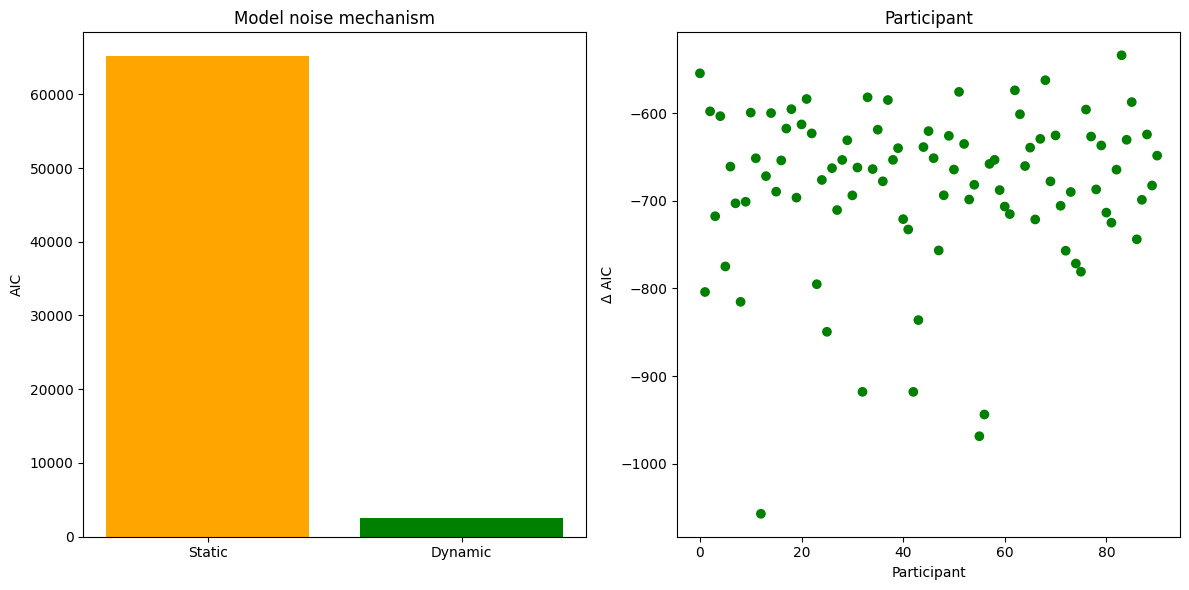

In [7]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load the dataset
data_path = 'TortoiseAndHareData.csv'
df = pd.read_csv(data_path)

# Extract relevant columns
columns = ['ID', 'learningblock', 'trial', 'ns', 'stim', 'iter', 'corchoice', 'choice', 'cor', 'rt', 'pcor', 'delay', 'phase']
df = df[columns]

# Ensure action values are within the valid range
df = df[df['choice'] >= 0]  # Remove invalid actions
df = df[df['choice'] < df['corchoice'].nunique()]  # Ensure actions are within valid range

# Parameters
subjects = df['ID'].unique()
num_states = df['stim'].nunique()
num_actions = df['corchoice'].nunique()

def softmax(Q, s, beta):
    exp_Q = np.exp(beta * Q[s] - np.max(beta * Q[s]))  # Subtract max for numerical stability
    return exp_Q / np.sum(exp_Q)

def q_learning_update(Q, s, a, r, alpha):
    prediction_error = r - Q[s, a]
    Q[s, a] += alpha * prediction_error
    return Q

def wm_update(W, s, a, r, phi):
    W[s, a] = r
    return W

def rlwm_static_model(params, actions, stimuli, rewards, num_states, num_actions):
    alpha, beta, epsilon, bias, K, phi, rho = params
    Q = np.zeros((num_states, num_actions))
    W = np.zeros((num_states, num_actions))
    log_likelihood = 0

    for t in range(len(actions)):
        s, a, r = stimuli[t], actions[t], rewards[t]

        if s >= num_states or s < 0 or a >= num_actions or a < 0:
            continue

        wm_contrib = min(1, K / num_states)
        mixed_policy = rho * softmax(W, s, beta) + (1 - rho) * softmax(Q, s, beta)
        action_prob = (1 - epsilon) * mixed_policy[a] + epsilon / num_actions

        if action_prob <= 0 or action_prob > 1:
            continue

        log_likelihood += np.log(action_prob)

        if r > 0:
            alpha_adjusted = alpha * (1 - bias)
        else:
            alpha_adjusted = alpha

        Q = q_learning_update(Q, s, a, r, alpha_adjusted)
        W = wm_update(W, s, a, r, phi)
        
    return -log_likelihood

def rlwm_dynamic_model(params, actions, stimuli, rewards, num_states, num_actions):
    alpha, beta, epsilon, bias, K, phi, rho, T0_1, T1_0 = params
    Q = np.zeros((num_states, num_actions))
    W = np.zeros((num_states, num_actions))
    log_likelihood = 0
    lambda_ = np.zeros(len(actions))
    lambda_[0] = 0.5  # initial probability of being in the random state
    
    for t in range(len(actions)):
        s, a, r = stimuli[t], actions[t], rewards[t]

        if s >= num_states or s < 0 or a >= num_actions or a < 0:
            continue

        wm_contrib = min(1, K / num_states)
        mixed_policy = rho * softmax(W, s, beta) + (1 - rho) * softmax(Q, s, beta)
        
        #if np.any(mixed_policy < 0):
            #print("Negative probabilities in mixed_policy:", mixed_policy)
        
        action_prob = (1 - lambda_[t - 1]) * mixed_policy[a] + lambda_[t - 1] / num_actions

        if action_prob <= 0 or action_prob > 1:
            continue

        log_likelihood += np.log(action_prob)

        if r > 0:
            alpha_adjusted = alpha * (1 - bias)
        else:
            alpha_adjusted = alpha

        Q = q_learning_update(Q, s, a, r, alpha_adjusted)
        W = wm_update(W, s, a, r, phi)

        if t > 0:
            lambda_[t] = (1 / num_actions) * lambda_[t - 1] * T0_1 + mixed_policy[a] * (1 - lambda_[t - 1]) * T1_0
            lambda_[t] /= ((1 / num_actions) * lambda_[t - 1] + mixed_policy[a] * (1 - lambda_[t - 1]))

    return -log_likelihood

# Define the objective function for optimization
def objective_function_static(params, df):
    log_likelihood = 0
    for subno in subjects:
        sub_df = df[df['ID'] == subno]
        actions = sub_df['choice'].values
        stimuli = sub_df['stim'].values
        rewards = sub_df['cor'].values
        log_likelihood += rlwm_static_model(params, actions, stimuli, rewards, num_states, num_actions)
    return log_likelihood

def objective_function_dynamic(params, df):
    log_likelihood = 0
    for subno in subjects:
        sub_df = df[df['ID'] == subno]
        actions = sub_df['choice'].values
        stimuli = sub_df['stim'].values
        rewards = sub_df['cor'].values
        log_likelihood += rlwm_dynamic_model(params, actions, stimuli, rewards, num_states, num_actions)
    return log_likelihood

# Initial guess for parameters
initial_params_static = [0.1, 5.0, 0.5, 0.1, 3, 0.1, 0.5]
initial_params_dynamic = [0.1, 5.0, 0.05, 0.1, 3, 0.1, 0.5, 0.5, 0.5]  # Broader initial guess for T0_1 and T1_0

# Set bounds for the parameters to ensure they stay within a reasonable range
bounds_static = [(0, 1), (0, 10), (0, 1), (-1, 1), (1, 10), (0, 1), (0, 2)]
bounds_dynamic = [(0, 1), (0, 10), (0, 1), (-1, 1), (1, 10), (0, 1), (0, 2), (0, 1), (0, 1)]

# Optimize parameters for static model
result_static = minimize(objective_function_static, initial_params_static, args=(df,), bounds=bounds_static)
print("Fitted parameters (static):", result_static.x)
print("Log likelihood (static):", -result_static.fun)

# Optimize parameters for dynamic model
result_dynamic = minimize(objective_function_dynamic, initial_params_dynamic, args=(df,), bounds=bounds_dynamic)
print("Fitted parameters (dynamic):", result_dynamic.x)
print("Log likelihood (dynamic):", -result_dynamic.fun)

# Calculate AIC
def calculate_aic(log_likelihood, num_params):
    return 2 * num_params - 2 * log_likelihood

# Group-level AIC
aic_static = calculate_aic(-result_static.fun, len(result_static.x))
aic_dynamic = calculate_aic(-result_dynamic.fun, len(result_dynamic.x))

# Calculate differences in AIC for each participant
aic_diff = []
print(subjects)
for subno in subjects:
    sub_df = df[df['ID'] == subno]
    actions = sub_df['choice'].values
    stimuli = sub_df['stim'].values
    rewards = sub_df['cor'].values
    
    ll_static = -rlwm_static_model(result_static.x, actions, stimuli, rewards, num_states, num_actions)
    ll_dynamic = -rlwm_dynamic_model(result_dynamic.x, actions, stimuli, rewards, num_states, num_actions)
    
    aic_static_sub = calculate_aic(ll_static, len(result_static.x))
    aic_dynamic_sub = calculate_aic(ll_dynamic, len(result_dynamic.x))
    
    aic_diff.append(aic_dynamic_sub - aic_static_sub)

# Plot AIC differences
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Group level AIC difference
ax[0].bar(['Static', 'Dynamic'], [aic_static, aic_dynamic], color=['orange', 'green'])
ax[0].set_title('Model noise mechanism')
ax[0].set_ylabel('AIC')
#ax[0].set_ylim([-1.5, 1.5])

# Individual level AIC differences
participants = range(len(subjects))
ax[1].scatter(participants, aic_diff, color=['orange' if diff > 0 else 'green' for diff in aic_diff])
ax[1].set_title('Participant')
ax[1].set_ylabel('Δ AIC')
ax[1].set_xlabel('Participant')
#ax[1].set_ylim([-30, 10])

plt.tight_layout()
plt.show()
